In [1]:
import sys
print(sys.version)

3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:14:23) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
"""
Created on Nov 1 2019
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [4]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [5]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [145]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

#Zernike_Module_lastOct15_beforeScatterChange
import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [253]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

## unit test 

In [33]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([24,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1)   

res=model(allparameters_proposal,return_Image=True)
print(res[0])

version of the code is: 0.22b
-3305.0422058032723


In [34]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

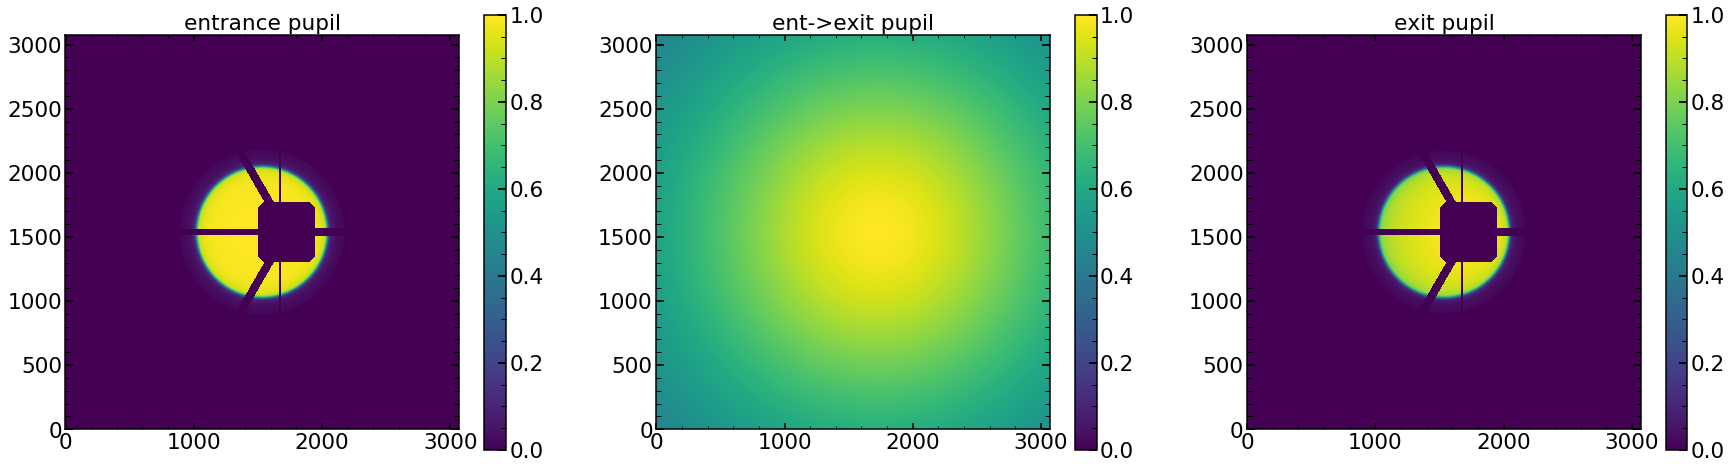

In [35]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

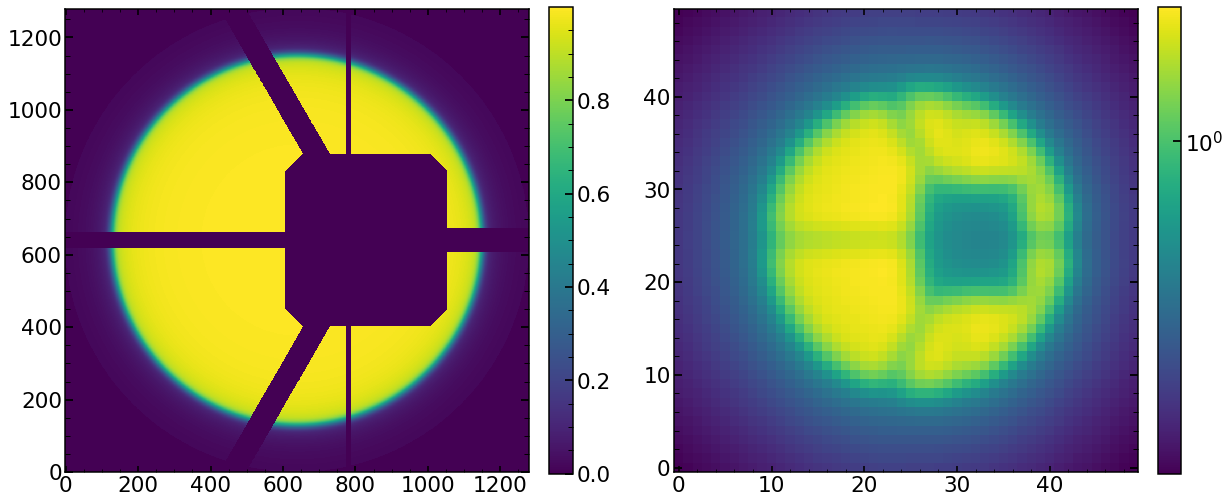

In [36]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([1,10**-2,10**-3,10**-4,10**-5,10,10**2,10**3,10**4,10**5])

# Nov 1 - focus and fine defocus 

## preparation of the fine focus arrays for initial solution

In [175]:
# single example 

with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/' + 'results_of_fit_many_direct_HgAr_from_Sep11.pkl', 'rb') as f:
    results_of_fit_many_single_focus_HgAr_pd=pickle.load(f)

with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Aug160119/' + 'results_of_fit_many_direct_HgAr_from_Aug16.pkl', 'rb') as f:
    results_of_fit_many_direct_preDecemberrun_HgAr=pickle.load(f)

  
# defocus
date='Aug16'
result_analysis=Zernike_result_analysis(date,single_number,'HgAr',22,4)
# result from the defocused analysis
results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
result_analysis.create_results_of_fit_single()

solution_at_0,solution_at_05_0_05=result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                      err_results_of_fit_single_lower,err_results_of_fit_single_upper,plot=False,return_solution_at_05_0_05=True)

# result from the focused analysis 
date='Sep11'
result_analysis=Zernike_result_analysis(date,single_number,'HgAr',22,4)

results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single_focus()
results_of_fit_single.values  

69 obs (Emcee3, defocus): 21352 is found!
69 obs (Emcee3, defocus): 21358 is found!
69 obs (Emcee3, defocus): 21364 is found!
69 obs (Emcee3, defocus): 21382 is found!
69 obs (Emcee3, defocus): 21394 is found!
69 obs (Emcee3, defocus): 21400 is found!
69 obs (Emcee3, defocus): 21400 is found!
69 obs (Emcee3, defocus): 21406 is found!
69 obs (Emcee3, defocus): 21418 is found!
69 obs (Emcee3, defocus): 21436 is found!
69 obs (Emcee3, defocus): 21442 is found!
69 obs (Emcee3, defocus): 21448 is found!
69 obs (Emcee3, defocus): 21394 is found!
69 obs (Emcee3, focus): 21400 is found!


array([[   -0.0024655 ,    -0.22296836,    -0.76322274,     0.00264255,
           -0.17435422,    -0.12407426,    -0.34792572,    -0.21386519,
            0.02158434,    -0.01050021,     0.03725648,     0.03335917,
           -0.01799691,     0.02699974,     0.01353157,     0.00581591,
           -0.03151583,     0.02603183,     0.0316521 ,     0.65565975,
            0.08167333,    -0.01059663,     0.14655529,     0.06324768,
            0.03293937,     0.00000776,     0.00000774,     0.97301666,
            0.94833994,    -0.0329702 ,    -0.03504737,     0.92511991,
            0.06225363,     0.79655482,     1.06035764,     0.03167464,
        46421.63067869,     2.75714699,     0.00555446,     0.42348078,
            1.81425702,     0.99587193,    29.1525251 ,  6552.49169922]])

In [188]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_May2019.pkl', 'rb') as f:
    finalNe_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl', 'rb') as f:
    finalHgAr_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_May2019.pkl', 'rb') as f:
    finalKr_May2019=pickle.load(f)  
    
finalKr=finalKr_May2019
finalHgAr=finalHgAr_May2019
finalNe=finalNe_May2019


In [212]:
columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
       'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
      'x_fiber','y_fiber','effective_radius_illumination',
      'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
      'grating_lines','scattering_slope','scattering_amplitude',
      'pixel_effect','fiber_r','flux']  

date='Aug16'


columns22_analysis=columns22+['chi2','chi2max']


results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22))).reshape(-1,len(columns22)),\
                                                     index=finalHgAr.index,columns=columns22)
err_results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22))).reshape(-1,len(columns22)),\
                                                         index=finalHgAr.index,columns=columns22)

results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(results_of_fit_many_single_defocus_HgAr)
err_results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_HgAr)

results_of_fit_many_fine_defocus_HgAr = {'m05ff': results_of_fit_many_single_defocus_HgAr_pd.copy(), 
                       'm04ff' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm03ff' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm02ff' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm01ff' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0ff' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p01ff' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p02ff' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p03ff' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p04ff' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p05ff' :results_of_fit_many_single_defocus_HgAr_pd.copy()}

label=['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']

for single_number in range(1,len(finalHgAr)):
    # which date, which nubmer, which arc, how many z, which dataset    

    result_analysis=Zernike_result_analysis(date,single_number,'HgAr',22,4)
    # result from the defocused analysis
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single()

    solution_at_0,solution_at_05_0_05=result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                          err_results_of_fit_single_lower,err_results_of_fit_single_upper,plot=False,return_solution_at_05_0_05=True)
    
    for i in range(len(label)):
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            results_of_fit_many_fine_defocus_HgAr[label[i]].at[single_number]=solution_at_05_0_05[i]
     
    
for i in range(len(label)):        
    results_of_fit_many_fine_defocus_HgAr[label[i]]=results_of_fit_many_fine_defocus_HgAr[label[i]][np.abs(results_of_fit_many_fine_defocus_HgAr[label[i]]['z4'])>0]



1 obs (Emcee3, defocus): 21352 is found!
1 obs (Emcee3, defocus): 21358 is found!
1 obs (Emcee3, defocus): 21364 is found!
1 obs (Emcee3, defocus): 21382 is found!
1 obs (Emcee3, defocus): 21394 is found!
1 obs (Emcee3, defocus): 21400 is found!
1 obs (Emcee3, defocus): 21400 is found!
1 obs (Emcee3, defocus): 21406 is found!
1 obs (Emcee3, defocus): 21418 is found!
1 obs (Emcee3, defocus): 21436 is found!
1 obs (Emcee3, defocus): 21442 is found!
1 obs (Emcee3, defocus): 21448 is found!
1 obs (Emcee3, defocus): 21394 is found!
3 obs (Emcee3, defocus): 21352 is found!
3 obs (Emcee3, defocus): 21358 is found!
3 obs (Emcee3, defocus): 21364 is found!
3 obs (Emcee3, defocus): 21382 is found!
3 obs (Emcee3, defocus): 21394 is found!
3 obs (Emcee3, defocus): 21400 is found!
3 obs (Emcee3, defocus): 21400 is found!
3 obs (Emcee3, defocus): 21406 is found!
3 obs (Emcee3, defocus): 21418 is found!
3 obs (Emcee3, defocus): 21436 is found!
3 obs (Emcee3, defocus): 21442 is found!
3 obs (Emcee3, d

42 obs (Emcee3, defocus): 21358 is found!
42 obs (Emcee3, defocus): 21364 is found!
42 obs (Emcee3, defocus): 21382 is found!
42 obs (Emcee3, defocus): 21394 is found!
42 obs (Emcee3, defocus): 21400 is found!
42 obs (Emcee3, defocus): 21400 is found!
42 obs (Emcee3, defocus): 21406 is found!
42 obs (Emcee3, defocus): 21418 is found!
42 obs (Emcee3, defocus): 21436 is found!
42 obs (Emcee3, defocus): 21442 is found!
42 obs (Emcee3, defocus): 21448 is found!
42 obs (Emcee3, defocus): 21394 is found!
45 obs (Emcee3, defocus): 21352 is found!
45 obs (Emcee3, defocus): 21358 is found!
45 obs (Emcee3, defocus): 21364 is found!
45 obs (Emcee3, defocus): 21382 is found!
45 obs (Emcee3, defocus): 21394 is found!
45 obs (Emcee3, defocus): 21400 is found!
45 obs (Emcee3, defocus): 21400 is found!
45 obs (Emcee3, defocus): 21406 is found!
45 obs (Emcee3, defocus): 21418 is found!
45 obs (Emcee3, defocus): 21436 is found!
45 obs (Emcee3, defocus): 21442 is found!
45 obs (Emcee3, defocus): 21448 is

81 obs (Emcee3, defocus): 21352 is found!
81 obs (Emcee3, defocus): 21358 is found!
81 obs (Emcee3, defocus): 21364 is found!
81 obs (Emcee3, defocus): 21382 is found!
81 obs (Emcee3, defocus): 21394 is found!
81 obs (Emcee3, defocus): 21400 is found!
81 obs (Emcee3, defocus): 21400 is found!
81 obs (Emcee3, defocus): 21406 is found!
81 obs (Emcee3, defocus): 21418 is found!
81 obs (Emcee3, defocus): 21436 is found!
81 obs (Emcee3, defocus): 21442 is found!
81 obs (Emcee3, defocus): 21448 is found!
81 obs (Emcee3, defocus): 21394 is found!
83 obs (Emcee3, defocus): 21352 is found!
83 obs (Emcee3, defocus): 21358 is found!
83 obs (Emcee3, defocus): 21364 is found!
83 obs (Emcee3, defocus): 21382 is found!
83 obs (Emcee3, defocus): 21394 is found!
83 obs (Emcee3, defocus): 21400 is found!
83 obs (Emcee3, defocus): 21400 is found!
83 obs (Emcee3, defocus): 21406 is found!
83 obs (Emcee3, defocus): 21418 is found!
83 obs (Emcee3, defocus): 21436 is found!
83 obs (Emcee3, defocus): 21442 is

114 obs (Emcee3, defocus): 21394 is found!
117 obs (Emcee3, defocus): 21352 is found!
117 obs (Emcee3, defocus): 21358 is found!
117 obs (Emcee3, defocus): 21364 is found!
117 obs (Emcee3, defocus): 21382 is found!
117 obs (Emcee3, defocus): 21394 is found!
117 obs (Emcee3, defocus): 21400 is found!
117 obs (Emcee3, defocus): 21400 is found!
117 obs (Emcee3, defocus): 21406 is found!
117 obs (Emcee3, defocus): 21418 is found!
117 obs (Emcee3, defocus): 21436 is found!
117 obs (Emcee3, defocus): 21442 is found!
117 obs (Emcee3, defocus): 21448 is found!
117 obs (Emcee3, defocus): 21394 is found!
119 obs (Emcee3, defocus): 21352 is found!
119 obs (Emcee3, defocus): 21358 is found!
119 obs (Emcee3, defocus): 21364 is found!
119 obs (Emcee3, defocus): 21382 is found!
119 obs (Emcee3, defocus): 21394 is found!
119 obs (Emcee3, defocus): 21400 is found!
119 obs (Emcee3, defocus): 21400 is found!
119 obs (Emcee3, defocus): 21406 is found!
119 obs (Emcee3, defocus): 21418 is found!
119 obs (Em

In [215]:
results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22))).reshape(-1,len(columns22)),index=finalNe.index,columns=columns22)
err_results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22))).reshape(-1,len(columns22)),index=finalNe.index,columns=columns22)

results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(results_of_fit_many_single_defocus_Ne)
err_results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_Ne)



results_of_fit_many_fine_defocus_Ne = {'m05ff': results_of_fit_many_single_defocus_Ne_pd.copy(), 
                       'm04ff' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm03ff' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm02ff' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm01ff' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0ff' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p01ff' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p02ff' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p03ff' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p04ff' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p05ff' :results_of_fit_many_single_defocus_Ne_pd.copy()}

label=['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']


for single_number in range(1,len(finalNe)):
    # which date, which nubmer, which arc, how many z, which dataset    

    result_analysis=Zernike_result_analysis(date,single_number,'Ne',22,4)
    # result from the defocused analysis
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single()

    solution_at_0,solution_at_05_0_05=result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                          err_results_of_fit_single_lower,err_results_of_fit_single_upper,plot=False,return_solution_at_05_0_05=True)
    
    for i in range(len(label)):
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            results_of_fit_many_fine_defocus_Ne[label[i]].at[single_number]=solution_at_05_0_05[i]
     
    
for i in range(len(label)):        
    results_of_fit_many_fine_defocus_Ne[label[i]]=results_of_fit_many_fine_defocus_Ne[label[i]][np.abs(results_of_fit_many_fine_defocus_Ne[label[i]]['z4'])>0]


2 obs (Emcee3, defocus): 21556 is found!
2 obs (Emcee3, defocus): 21562 is found!
2 obs (Emcee3, defocus): 21568 is found!
2 obs (Emcee3, defocus): 21586 is found!
2 obs (Emcee3, defocus): 21598 is found!
2 obs (Emcee3, defocus): 21604 is found!
2 obs (Emcee3, defocus): 21604 is found!
2 obs (Emcee3, defocus): 21610 is found!
2 obs (Emcee3, defocus): 21622 is found!
2 obs (Emcee3, defocus): 21640 is found!
2 obs (Emcee3, defocus): 21646 is found!
2 obs (Emcee3, defocus): 21652 is found!
2 obs (Emcee3, defocus): 21604 is found!
5 obs (Emcee3, defocus): 21556 is found!
5 obs (Emcee3, defocus): 21562 is found!
5 obs (Emcee3, defocus): 21568 is found!
5 obs (Emcee3, defocus): 21586 is found!
5 obs (Emcee3, defocus): 21598 is found!
5 obs (Emcee3, defocus): 21604 is found!
5 obs (Emcee3, defocus): 21604 is found!
5 obs (Emcee3, defocus): 21610 is found!
5 obs (Emcee3, defocus): 21622 is found!
5 obs (Emcee3, defocus): 21640 is found!
5 obs (Emcee3, defocus): 21646 is found!
5 obs (Emcee3, d

47 obs (Emcee3, defocus): 21562 is found!
47 obs (Emcee3, defocus): 21568 is found!
47 obs (Emcee3, defocus): 21586 is found!
47 obs (Emcee3, defocus): 21598 is found!
47 obs (Emcee3, defocus): 21604 is found!
47 obs (Emcee3, defocus): 21604 is found!
47 obs (Emcee3, defocus): 21610 is found!
47 obs (Emcee3, defocus): 21622 is found!
47 obs (Emcee3, defocus): 21640 is found!
47 obs (Emcee3, defocus): 21646 is found!
47 obs (Emcee3, defocus): 21652 is found!
47 obs (Emcee3, defocus): 21604 is found!
50 obs (Emcee3, defocus): 21556 is found!
50 obs (Emcee3, defocus): 21562 is found!
50 obs (Emcee3, defocus): 21568 is found!
50 obs (Emcee3, defocus): 21586 is found!
50 obs (Emcee3, defocus): 21598 is found!
50 obs (Emcee3, defocus): 21604 is found!
50 obs (Emcee3, defocus): 21604 is found!
50 obs (Emcee3, defocus): 21610 is found!
50 obs (Emcee3, defocus): 21622 is found!
50 obs (Emcee3, defocus): 21640 is found!
50 obs (Emcee3, defocus): 21646 is found!
50 obs (Emcee3, defocus): 21652 is

88 obs (Emcee3, defocus): 21556 is found!
88obs (Emcee2, defocus): 21652 is found!


In [223]:
results_of_fit_many_single_defocus_Kr=pd.DataFrame(np.zeros((len(finalKr),len(columns22))).reshape(-1,len(columns22)),index=finalKr.index,columns=columns22)
err_results_of_fit_many_single_defocus_Kr=pd.DataFrame(np.zeros((len(finalKr),len(columns22))).reshape(-1,len(columns22)),index=finalKr.index,columns=columns22)

results_of_fit_many_single_defocus_Kr_pd=pd.DataFrame(results_of_fit_many_single_defocus_Kr)
err_results_of_fit_many_single_defocus_Kr_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_Kr)



results_of_fit_many_fine_defocus_Kr = {'m05ff': results_of_fit_many_single_defocus_Kr_pd.copy(), 
                       'm04ff' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm03ff' :  results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm02ff' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm01ff' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       '0ff' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p01ff' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p02ff' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p03ff' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p04ff' :  results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p05ff' :results_of_fit_many_single_defocus_Kr_pd.copy()}

label=['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']


for single_number in range(1,len(finalKr)):
    # which date, which nubmer, which arc, how many z, which dataset    

    result_analysis=Zernike_result_analysis(date,single_number,'Kr',22,4)
    # result from the defocused analysis
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single()

    solution_at_0,solution_at_05_0_05=result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                          err_results_of_fit_single_lower,err_results_of_fit_single_upper,plot=False,return_solution_at_05_0_05=True)
    
    for i in range(len(label)):
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            results_of_fit_many_fine_defocus_Kr[label[i]].at[single_number]=solution_at_05_0_05[i]
     
    
for i in range(len(label)):        
    results_of_fit_many_fine_defocus_Kr[label[i]]=results_of_fit_many_fine_defocus_Kr[label[i]][np.abs(results_of_fit_many_fine_defocus_Kr[label[i]]['z4'])>0]

3 obs (Emcee3, defocus): 21760 is found!
3 obs (Emcee3, defocus): 21766 is found!
3 obs (Emcee3, defocus): 21772 is found!
3 obs (Emcee3, defocus): 21790 is found!
3 obs (Emcee3, defocus): 21802 is found!
3 obs (Emcee3, defocus): 21808 is found!
3 obs (Emcee3, defocus): 21808 is found!
3 obs (Emcee3, defocus): 21814 is found!
3 obs (Emcee3, defocus): 21826 is found!
3 obs (Emcee3, defocus): 21844 is found!
3 obs (Emcee3, defocus): 21850 is found!
3 obs (Emcee3, defocus): 21856 is found!
3 obs (Emcee3, defocus): 21808 is found!
7 obs (Emcee3, defocus): 21760 is found!
7 obs (Emcee3, defocus): 21766 is found!
7 obs (Emcee3, defocus): 21772 is found!
7 obs (Emcee3, defocus): 21790 is found!
7 obs (Emcee3, defocus): 21802 is found!
7 obs (Emcee3, defocus): 21808 is found!
7 obs (Emcee3, defocus): 21808 is found!
7 obs (Emcee3, defocus): 21814 is found!
7 obs (Emcee3, defocus): 21826 is found!
7 obs (Emcee3, defocus): 21844 is found!
7 obs (Emcee3, defocus): 21850 is found!
7 obs (Emcee3, d

In [225]:
pd.reset_option("display.max_rows")
import pickle
DATAFRAMES_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/Aug160119/'
if not os.path.exists(DATAFRAMES_FOLDER):
    os.makedirs(DATAFRAMES_FOLDER )

with open(DATAFRAMES_FOLDER + 'results_of_fit_many_fine_defocus_direct_HgAr_from_Aug16.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_fine_defocus_HgAr,f, protocol=pickle.HIGHEST_PROTOCOL)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_fine_defocus_direct_Ne_from_Aug16.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_fine_defocus_Ne,f, protocol=pickle.HIGHEST_PROTOCOL)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_fine_defocus_direct_Kr_from_Aug16.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_fine_defocus_Kr,f, protocol=pickle.HIGHEST_PROTOCOL)

## scripts 

In [231]:
DATAFRAMES_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/Aug160119/'

# where are the dataframe which we use to guess the initial solution
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_HgAr_from_Aug16.pkl', 'rb') as f:
    results_of_fit_many_direct_preDecemberrun_HgAr=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ne_from_Aug16.pkl', 'rb') as f:
    results_of_fit_many_direct_preDecemberrun_Ne=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Kr_from_Aug16.pkl', 'rb') as f:
    results_of_fit_many_direct_preDecemberrun_Kr=pickle.load(f)
    

In [241]:
list_of_HgAr_to_analyze=results_of_fit_many_fine_defocus_HgAr['0ff'].index.values
print(len(list_of_HgAr_to_analyze))

list_of_Ne_to_analyze=results_of_fit_many_fine_defocus_Ne['0ff'].index.values
print(len(list_of_Ne_to_analyze))

list_of_Kr_to_analyze=results_of_fit_many_fine_defocus_Kr['0ff'].index.values
print(len(list_of_Kr_to_analyze))


46
29
9


In [251]:
list_of_HgAr_to_analyze

array([  1,   3,   9,  11,  15,  18,  21,  23,  27,  30,  33,  35,  37,
        39,  42,  45,  47,  49,  51,  54,  57,  59,  61,  66,  69,  71,
        73,  75,  78,  81,  83,  85,  87,  90,  93,  95,  97,  99, 102,
       105, 107, 109, 111, 114, 117, 119])

In [285]:
#MPI
for single_spot in list_of_HgAr_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T01S'+str(single_spot)+'Nov.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 09:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # ['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']
    for obs in np.arange(21280,21280+11*6,6):
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Nov_MPI01_fine_focus.py "+str(obs)+" "+str(single_spot)+" 40 5 HgAr 5\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/NovScriptToSubmitScriptsTiger01'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T01S'+str(single_spot)+'Nov.sh \n')

file.close()
##################
##################
##################

for single_spot in list_of_Ne_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T02S'+str(single_spot)+'Nov.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 09:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # ['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']
    for obs in np.arange(21484,21484+11*6,6):
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Nov_MPI01_fine_focus.py "+str(obs)+" "+str(single_spot)+" 40 5 Ne 5\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/NovScriptToSubmitScriptsTiger02'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T02S'+str(single_spot)+'Nov.sh \n')

file.close()

##################
##################
##################
for single_spot in list_of_Kr_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T03S'+str(single_spot)+'Nov.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 09:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # ['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']
    for obs in np.arange(21688,21688+11*6,6):
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Nov_MPI01_fine_focus.py "+str(obs)+" "+str(single_spot)+" 40 5 Kr 5\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/NovScriptToSubmitScriptsTiger03'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T03S'+str(single_spot)+'Nov.sh \n')

file.close()

In [252]:
finalKr=finalKr_May2019
finalHgAr=finalHgAr_May2019
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_May2019.pkl', 'rb') as f:
    finalNe_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl', 'rb') as f:
    finalHgAr_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_May2019.pkl', 'rb') as f:
    finalKr_May2019=pickle.load(f)  
    
finalKr=finalKr_May2019
finalHgAr=finalHgAr_May2019
finalNe=finalNe_May2019

In [286]:

date='Nov05'
Emcee3_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5NeEmcee3.npy', recursive=True)
Emcee3_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5HgArEmcee3.npy', recursive=True)
Emcee3_Kr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5KrEmcee3.npy', recursive=True)

In [287]:
analyzed_Neon_images=[]
for i in range(len(Emcee3_Ne)):
    single_string=Emcee3_Ne[i][90:len(Emcee3_Ne[0])-13]
    analyzed_Neon_images.append([int(single_string[:5]),int(single_string[5:])])
   
analyzed_Neon_images=np.array(analyzed_Neon_images)
###########
analyzed_HgAr_images=[]
for i in range(len(Emcee3_HgAr)):
    single_string=Emcee3_HgAr[i][90:len(Emcee3_HgAr[i])-15]
    analyzed_HgAr_images.append([int(single_string[:5]),int(single_string[5:])])
 

analyzed_HgAr_images=np.array(analyzed_HgAr_images)
###########
analyzed_Kr_images=[]
for i in range(len(Emcee3_Kr)):
    single_string=Emcee3_Kr[i][90:len(Emcee3_Kr[i])-13]
    analyzed_Kr_images.append([int(single_string[:5]),int(single_string[5:])])
    
analyzed_Kr_images=np.array(analyzed_Kr_images)

In [288]:
arranged_by_defocus_Ne=analyzed_Neon_images[analyzed_Neon_images[:,0].argsort()]
arranged_by_spot_number_Ne=analyzed_Neon_images[analyzed_Neon_images[:,1].argsort()]

arranged_by_defocus_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,0].argsort()]
arranged_by_spot_number_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,1].argsort()]

arranged_by_defocus_Kr=analyzed_Kr_images[analyzed_Kr_images[:,0].argsort()]
arranged_by_spot_number_Kr=analyzed_Kr_images[analyzed_Kr_images[:,1].argsort()]

IndexError: too many indices for array

In [257]:
analyzed_Kr_images

array([], dtype=float64)

In [289]:
analyzed_HgAr_images

array([[21292,     3],
       [21316,     1],
       [21280,    42],
       [21334,     3],
       [21280,    59],
       [21340,     1],
       [21310,     3],
       [21322,     3],
       [21322,     1],
       [21334,     1],
       [21310,     1],
       [21340,     3],
       [21316,     3],
       [21292,     1],
       [21304,     1],
       [21280,     3],
       [21298,     1],
       [21328,     1],
       [21286,     1],
       [21286,     3],
       [21328,     3],
       [21298,     3],
       [21280,     1],
       [21304,     3]])

In [259]:
analyzed_Neon_images

array([], dtype=float64)

## single analysis 

In [304]:

date='Nov05'
obs=21286
obs_int=int(obs)
single_number='1'
image_index=int(single_number)
eps=5
arc='HgAr'
dataset=5

if dataset==2:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/"
if dataset==3:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/"
if dataset==4 or dataset==5:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"    

if dataset==1:
    if arc=="HgAr":
        single_number_focus=11748
    elif arc=="Ne":
        single_number_focus=11748+607    
    else:
        print("Not recognized arc-line")
        
if dataset==2:
    if arc=="HgAr":
        single_number_focus=17017+54
    elif arc=="Ne":
        single_number_focus=16292  
    elif arc=="Kr":
        single_number_focus=17364  
    else:
        print("Not recognized arc-line")
        
if dataset==3:
    if arc=="HgAr":
        single_number_focus=19238+54
    elif arc=="Ne":
        single_number_focus=19472  
    else:
        print("Not recognized arc-line")
      
if dataset==4 or dataset==5:
    if arc=="HgAr":
        single_number_focus=21346+54
    elif arc=="Ne":
        single_number_focus=21550 +54 
    elif arc=="Kr":
        single_number_focus=21754  +54 
    else:
        print("Not recognized arc-line")    
    
if dataset==1:
    if arc=='HgAr':
        obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
    elif arc=='Ne':
        obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
        
if dataset==2:
    if arc=='HgAr':
        obs_possibilites=np.array([17023,17023+6,17023+12,17023+18,17023+24,17023+30,17023+36,17023+42,17023+48,17023+48,\
                                   17023+54,17023+60,17023+66,17023+72,17023+78,17023+84,17023+90,17023+96,17023+48])
    if arc=='Ne':
        # different sequence than for HgAr
        obs_possibilites=np.array([16238+6,16238+12,16238+18,16238+24,16238+30,16238+36,16238+42,16238+48,16238+54,16238+54,\
                                   16238+60,16238+66,16238+72,16238+78,16238+84,16238+90,16238+96,16238+102,16238+54])
    if arc=='Kr':
         obs_possibilites=np.array([17310+6,17310+12,17310+18,17310+24,17310+30,17310+36,17310+42,17310+48,17310+54,17310+54,\
                                    17310+60,17310+66,17310+72,17310+78,17310+84,17310+90,17310+96,17310+102,17310+54])

if dataset==3:    
    if arc=='HgAr':
        obs_possibilites=np.array([19238,19238+6,19238+12,19238+18,19238+24,19238+30,19238+36,19238+42,19238+48,19238+48,\
                                   19238+54,19238+60,19238+66,19238+72,19238+78,19238+84,19238+90,19238+96,19238+48])
    elif arc=='Ne':
    # different sequence than for HgAr
        obs_possibilites=np.array([19472+6,19472+12,19472+18,19472+24,19472+30,19472+36,19472+42,19472+48,19472+54,19472+54,\
                                   19472+60,19472+66,19472+72,19472+78,19472+84,19472+90,19472+96,19472+102,19472+54]) 
  
if dataset==4:
    if arc=='HgAr':
        obs_possibilites=np.array([21346+6,21346+12,21346+18,21346+24,21346+30,21346+36,21346+42,21346+48,21346+54,21346+54,\
                                   21346+60,21346+66,21346+72,21346+78,21346+84,21346+90,21346+96,21346+102,21346+48])
    if arc=='Ne':
        obs_possibilites=np.array([21550+6,21550+12,21550+18,21550+24,21550+30,21550+36,21550+42,21550+48,21550+54,21550+54,\
                                   21550+60,21550+66,21550+72,21550+78,21550+84,21550+90,21550+96,21550+102,21550+54])
    if arc=='Kr':
         obs_possibilites=np.array([21754+6,21754+12,21754+18,21754+24,21754+30,21754+36,21754+42,21754+48,21754+54,21754+54,\
                                    21754+60,21754+66,21754+72,21754+78,21754+84,21754+90,21754+96,21754+102,21754+54])
 
if dataset==5:
    if arc=='HgAr':
        obs_possibilites=np.arange(21280,21280+11*6,6)
    if arc=='Ne':
        obs_possibilites=np.arange(21484,21484+11*6,6)
    if arc=='Kr':
         obs_possibilites=np.arange(21688,21688+11*6,6)



label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
label_fine_defocus=['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']
if dataset in [0,1,2,3,4]:
    labelInput=label[list(obs_possibilites).index(obs_int)]
if dataset in [5]:
    labelInput=label_fine_defocus[list(obs_possibilites).index(obs_int)]
    
    
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

if dataset==1:
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2019
    elif arc=="Ne":
        finalArc=finalNe_Feb2019    
    else:
        print("Not recognized arc-line")  
        
if dataset==2:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==3:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==4 or dataset==5:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")           
        
finalArc.loc[int(single_number)]

m04ff


fiber                           2
xc                             69
yc                            875
wavelength               696.7261
close                           1
lamp                         HgAr
xc_effective                   69
old_index_approx                1
superold_index_approx        90.0
Name: 1, dtype: object

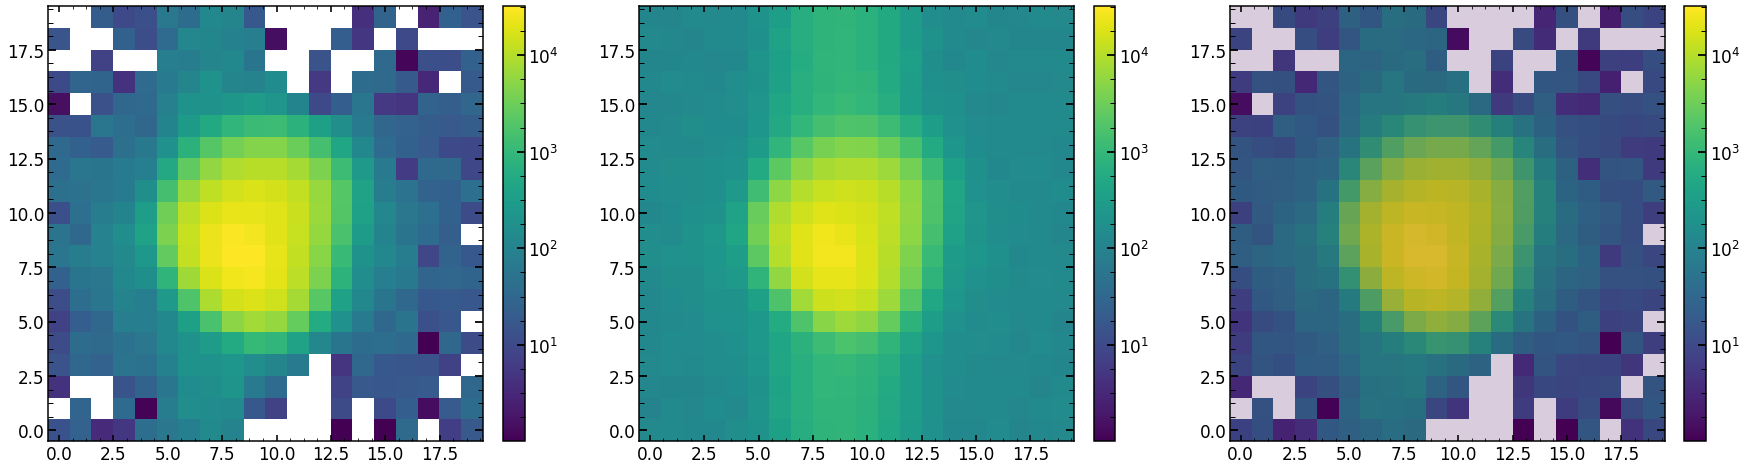

In [305]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(132)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(133)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(mask_image,origin='lower',vmin=0,vmax=np.max(mask_image),alpha=0.2)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
#cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [306]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc,dataset)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()

minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 1956.5986240199788
minimal chi2 reduced is: 9.74452375664815


In [307]:
print(minchain.shape)

if len(minchain)==42:
    columns=columns22
    
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

(42,)
         z4        z5        z6        z7        z8        z9       z10  \
0  3.830002  0.138086 -0.140395  0.524284  0.712249  0.201181 -0.293488   

        z11  
0  0.004563  
        z12       z13       z14       z15       z16       z17       z18  \
0 -0.093795 -0.128482  0.014295  0.028578 -0.015323  0.034244 -0.001378   

        z19       z20       z21  
0  0.031519 -0.033881  0.008871  
        z22   hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.042601  0.683646   0.100065 -0.186171 -0.038882  0.053161     0.056835   

   radiometricEffect  radiometricExponent    x_ilum  ...  frd_sigma  \
0           0.000041             0.000041  0.974929  ...   0.061427   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0            0.623671  0.996251            0.409946   30643.010418   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r      flux  
0          2.027652              0.000935          0.35  1.824902  0.998198

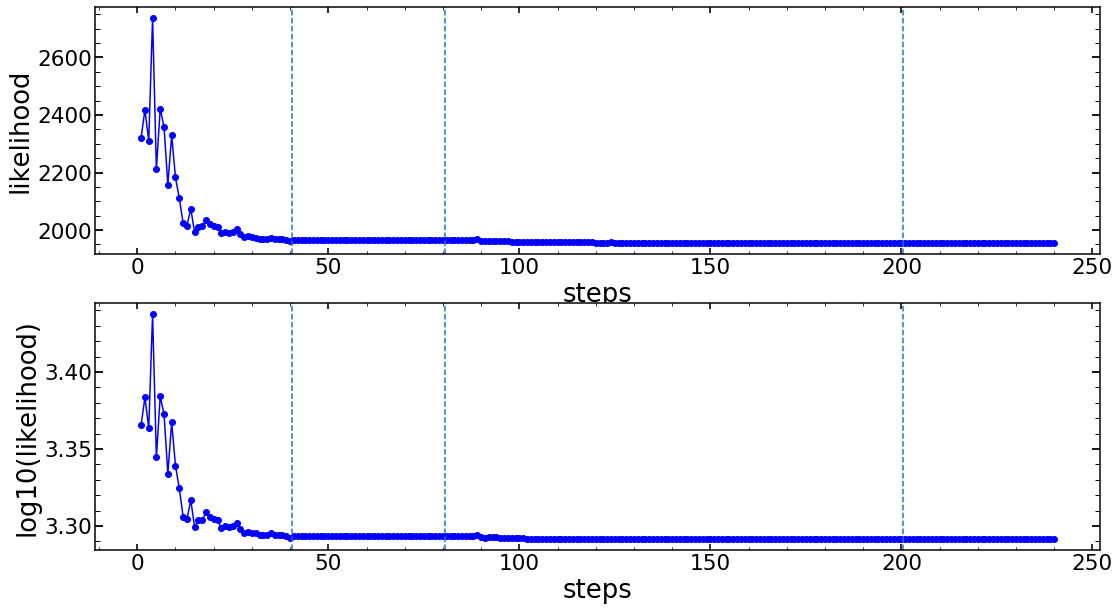

In [308]:
size=chain0_Emcee3.shape[1]
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(18,10))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-',marker='o')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(5*size+0.5,ls='--')

In [309]:
model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22)   
#minchain_new=np.copy(minchain)   
#minchain_new[0]=10
#minchain_new[1]=5
model(minchain)

-1956.5986240199616

In [310]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')
res_init=np.load(TESTING_FINAL_IMAGES_FOLDER+'res_init.npy')
res=np.load(TESTING_FINAL_IMAGES_FOLDER+'res.npy')

optPsf_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut.npy')
optPsf_cut_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled.npy')
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

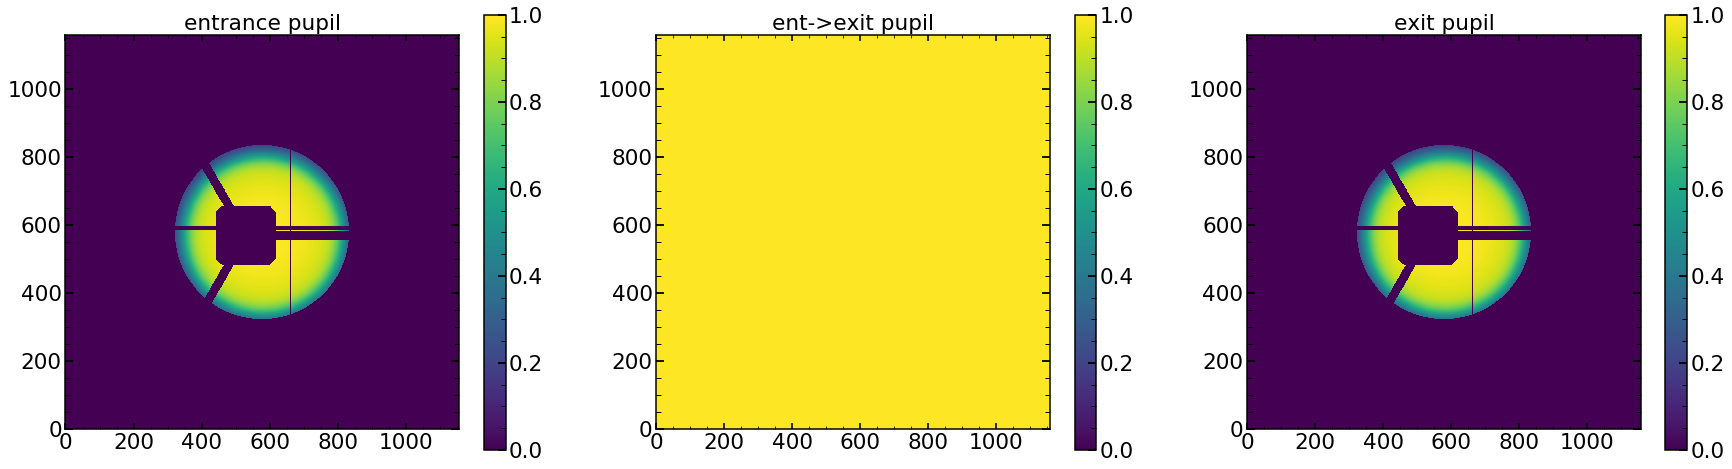

In [311]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

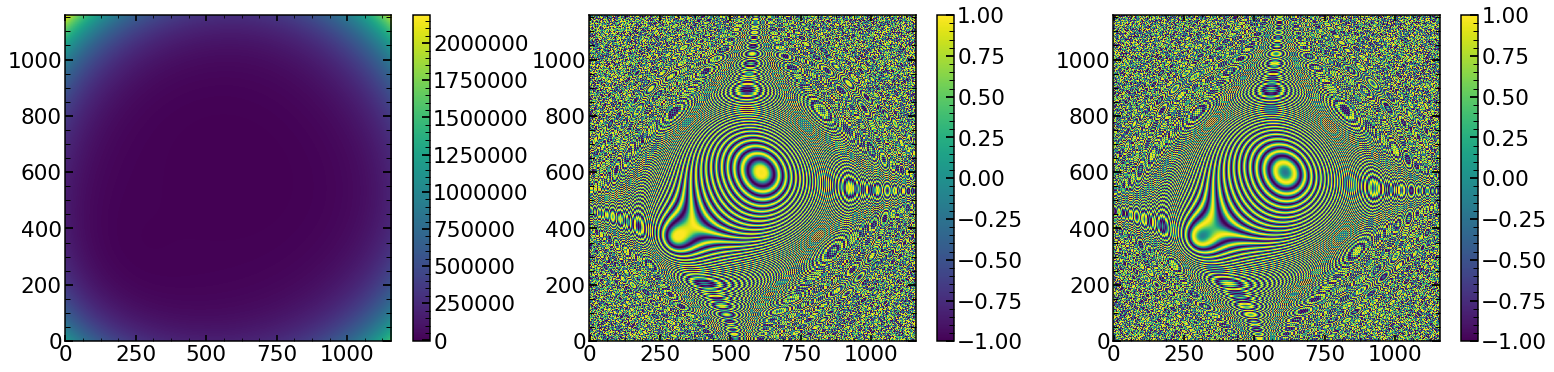

In [312]:
plt.figure(figsize=(36,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

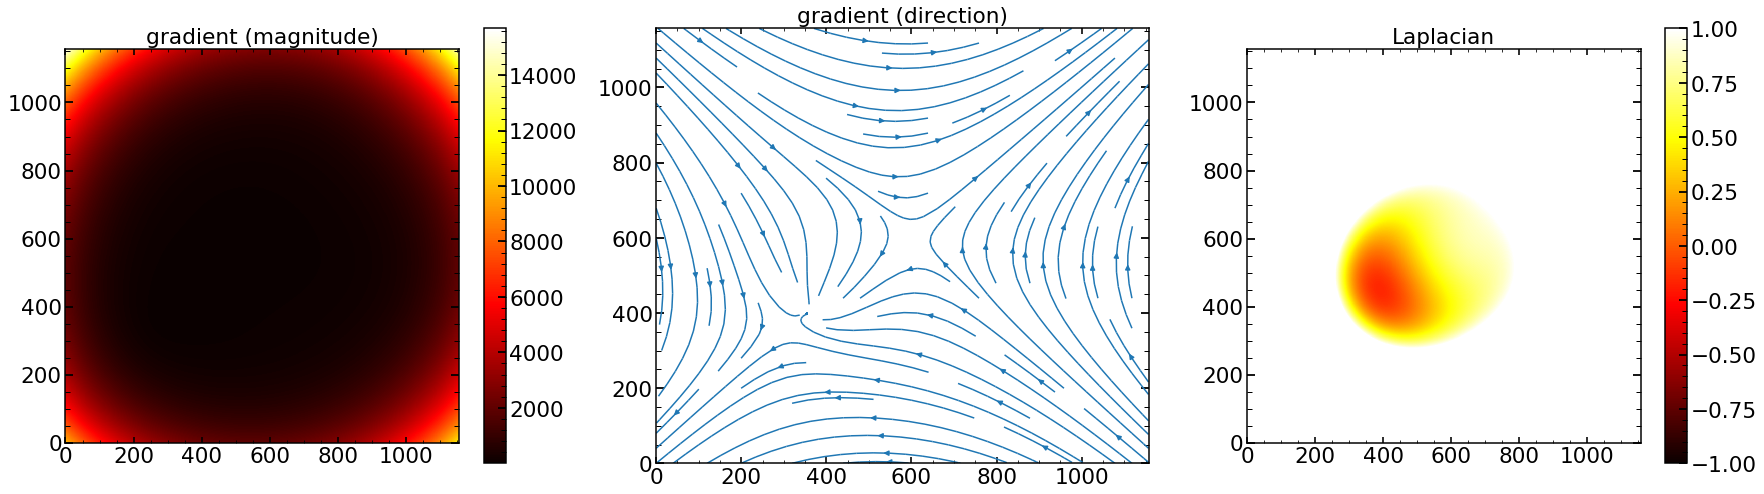

In [313]:
plt.figure(figsize=(30,8))
plt.subplot(131)
vgrad = np.gradient(wf_full)
fulgrad = np.sqrt(vgrad[0]**2 + vgrad[1]**2)
plt.title('gradient (magnitude)')
plt.imshow(fulgrad,cmap=plt.get_cmap('hot'), vmin = np.amin(fulgrad),vmax = np.amax(fulgrad))  
plt.colorbar()
plt.subplot(132)
x, y = range(0, len(wf_full)), range(0,len(wf_full))
xi, yi = np.meshgrid(x, y)
plt.title('gradient (direction)')
plt.streamplot(xi, yi, vgrad[0], vgrad[1])
plt.subplot(133)
laplace_of_wf = scipy.ndimage.filters.laplace(wf_full)
plt.title('Laplacian')
plt.imshow(laplace_of_wf,cmap=plt.get_cmap('hot'), vmin = -1,vmax = 1) 
plt.colorbar()

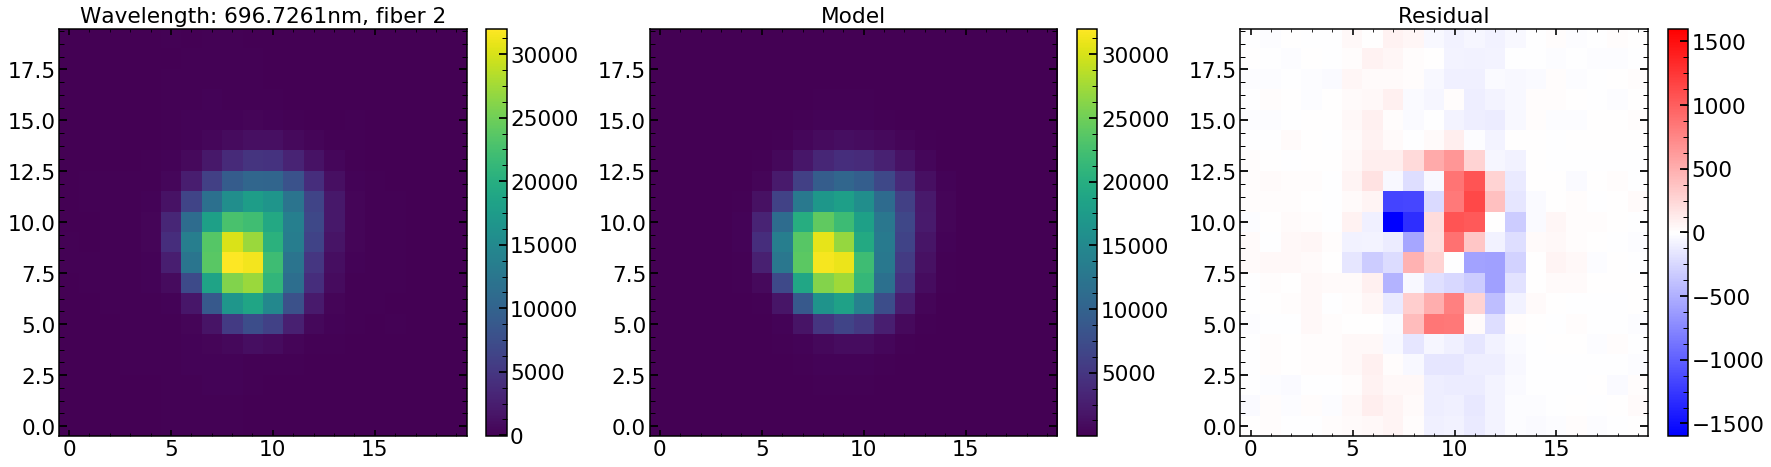

In [314]:
plt.figure(figsize=(30,7.5))
plt.subplot(1,3,1)
plt.imshow(sci_image,vmax=np.max(sci_image))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Wavelength: ' +str(finalArc.loc[int(single_number)]['wavelength'])+'nm, fiber '+str(finalArc.loc[int(single_number)]['fiber']))
# plt.title('Data taken on '+str(date)+', '+str(finalArc.loc[int(single_number)]['wavelength'])+'nm, fiber '+str(finalArc.loc[int(single_number)]['fiber']))
plt.subplot(1,3,2)
plt.imshow(res_iapetus,vmax=np.max(sci_image))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Model')
plt.subplot(1,3,3)
plt.imshow(sci_image-res_iapetus,vmin=-np.max(sci_image)/20,vmax=np.max(sci_image)/20,cmap='bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Residual')

plt.savefig('/Users/nevencaplar/Documents/Jobs/Figures/' + 'PSF_example.pdf', bbox_inches='tight')

chi**2 reduced is: 9.74452390290354
Abs of residual divided by total flux is: 0.047157960122815146
Abs of residual divided by largest value of a flux in the image is: 0.05624074399605745


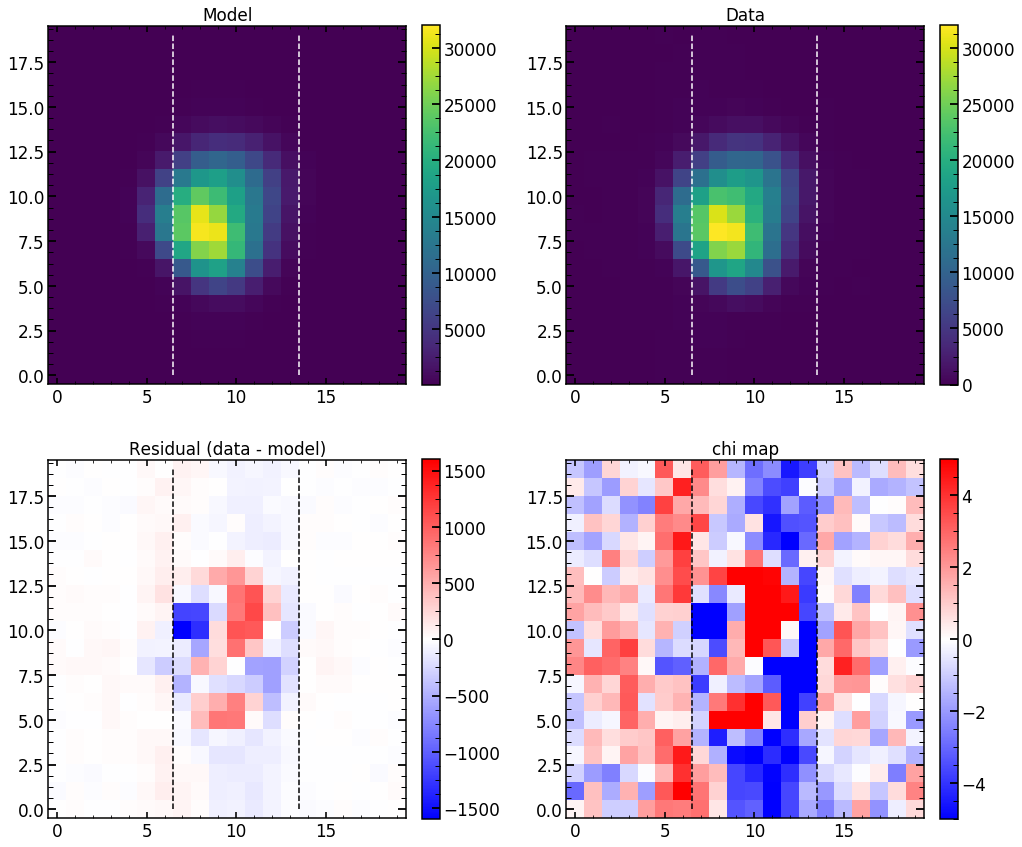

In [315]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

9.74452390290354
chi**2 reduced is: 9.74452390290354
Abs of residual divided by total flux is: 0.047157960122815146
Abs of residual divided by largest value of a flux in the image is: 0.05624074399605745


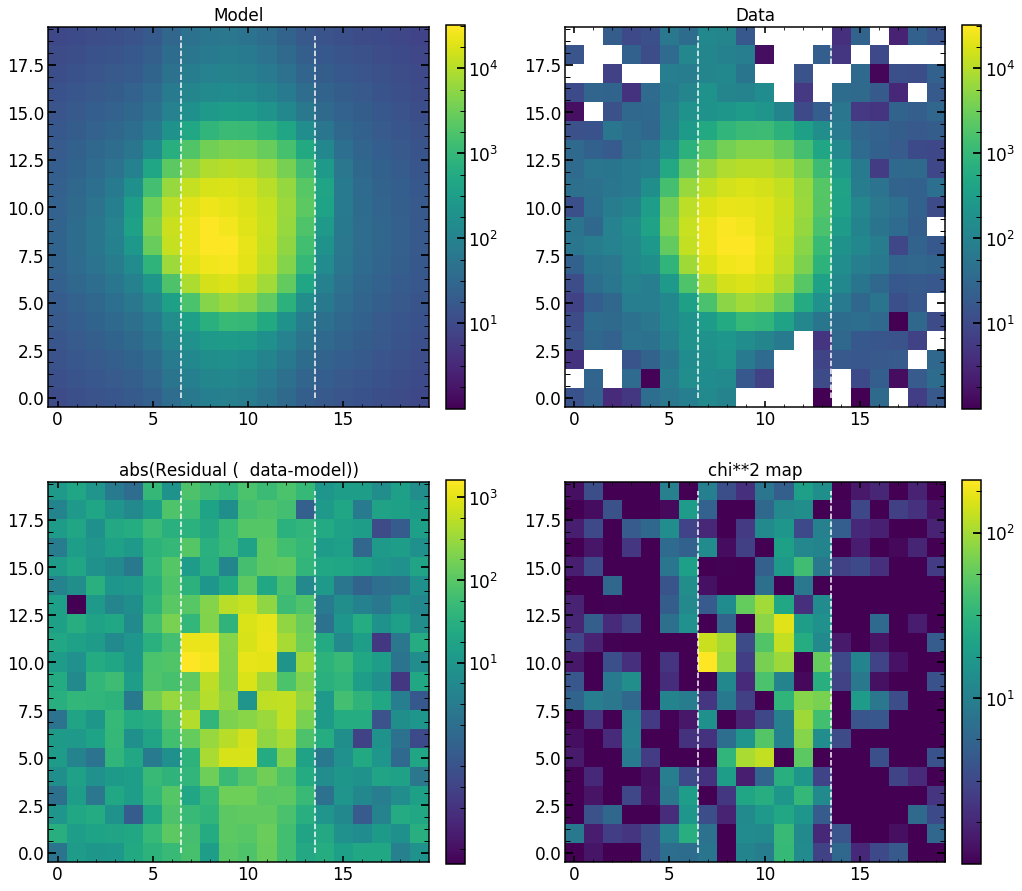

In [316]:
single_analysis.create_basic_comparison_plot_log()

9.74452390290354
chi**2 reduced is: 9.74452390290354
Abs of residual divided by total flux is: 0.047157960122815146
Abs of residual divided by largest value of a flux in the image is: 0.05624074399605745


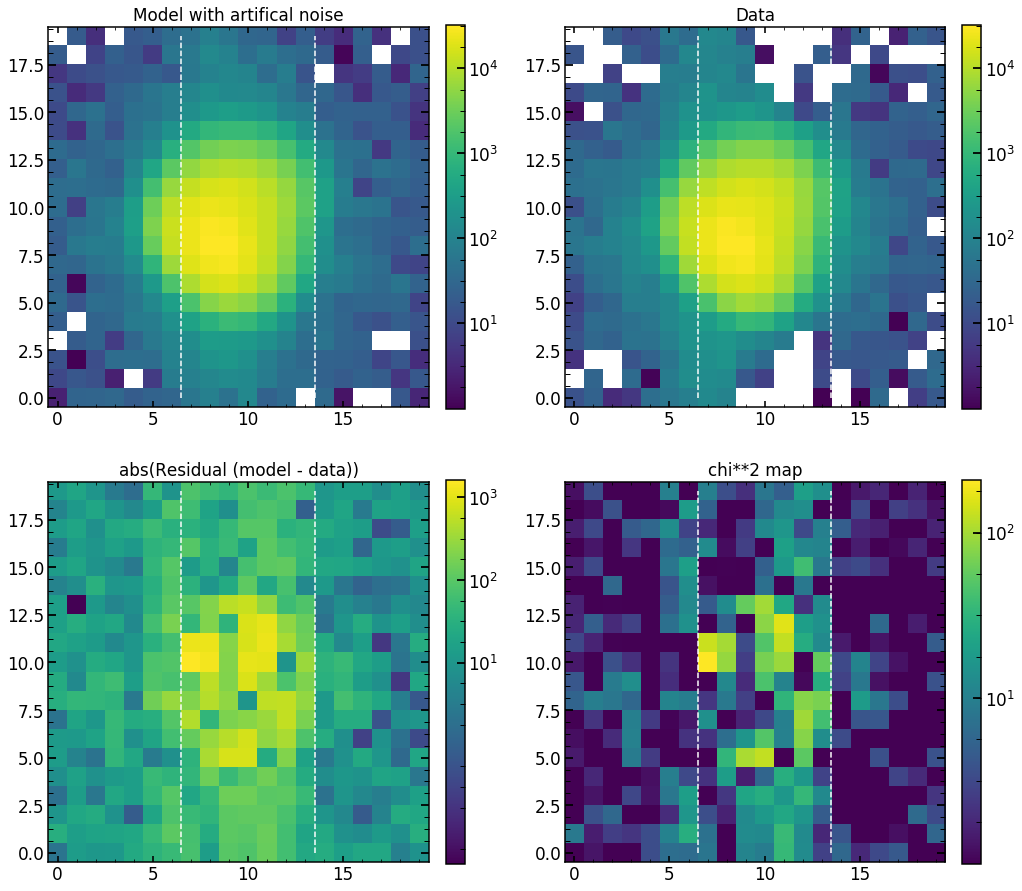

In [317]:
single_analysis.create_basic_comparison_plot_log_artifical()

# Poster work